## Downloading & preparing the Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay
import re
import string
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
# Ignore FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sentiment-analysis-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F989445%2F1808590%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240418%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240418T100202Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D37697dd0d9910676a3f12986b24306fc3726be4de82536c784ffb79deff0ba33d8973d6d612a53bcf9ed39bd7ad8a1d69bb34c42a34c7d6cffee6dd3048a9ef68f047745664f48ea6f3773a1f263129a6f78d48923235cc363b4081daadea014b0958575bf8376d565858404a8b1be7e5f317bdd9f5823ce4777f0b7052445c648bcda039294c804978828087705abe4416a6f9a0e0743388667017128a5ab2ef5ab2dade0d40d1659f4313296501907b4baec3161131e151e6f5b982eee9a6f7eb1b022da9c874f216d7fac981dc1351e9001ee56d03d1da8b2e0d4c97320f18d7e9b00ec63f4ba7444d81595cc8edff2b05f13aef4b204dd2710d0fddf0ef9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 57092644 bytes downloaded
Downloaded and uncompressed: sentiment-analysis-dataset
Data source import complete.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment-analysis-dataset/testdata.manual.2009.06.14.csv
/kaggle/input/sentiment-analysis-dataset/test.csv
/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
/kaggle/input/sentiment-analysis-dataset/train.csv


In [4]:
d = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/train.csv',encoding='latin1');
f = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/test.csv',encoding='latin1');
df = pd.concat([d,f])

In [5]:
print(df.shape)
display(df.info())
display(df)

(32296, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 32296 entries, 0 to 4814
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            31015 non-null  object 
 1   text              31014 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         31015 non-null  object 
 4   Time of Tweet     31015 non-null  object 
 5   Age of User       31015 non-null  object 
 6   Country           31015 non-null  object 
 7   Population -2020  31015 non-null  float64
 8   Land Area (Km²)   31015 non-null  float64
 9   Density (P/Km²)   31015 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.7+ MB


None

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0
...,...,...,...,...,...,...,...,...,...,...
4810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocessing the dataset

In [6]:
df.dropna(inplace=True)

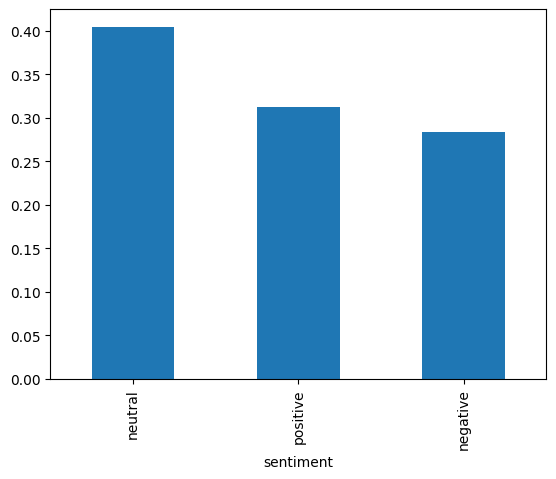

In [7]:
df['sentiment'].value_counts(normalize=True).plot(kind='bar');

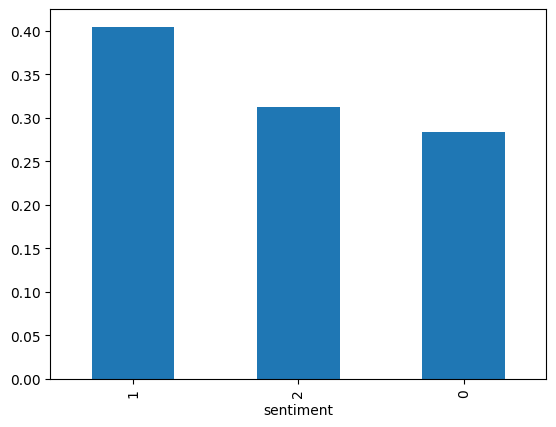

In [8]:
df['sentiment'] = df['sentiment'].astype('category').cat.codes
df['sentiment'].value_counts(normalize=True).plot(kind='bar');

In [9]:
df['Time of Tweet'] = df['Time of Tweet'].astype('category').cat.codes
# Convert Country column to categorical variable
df['Country'] = df['Country'].astype('category').cat.codes
# convert Age of User to integer
df['Age of User']=df['Age of User'].replace({'0-20':18,'21-30':25,'31-45':38,'46-60':53,'60-70':65,'70-100':80})

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27480 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27480 non-null  int8   
 4   Time of Tweet     27480 non-null  int8   
 5   Age of User       27480 non-null  int64  
 6   Country           27480 non-null  int16  
 7   Population -2020  27480 non-null  float64
 8   Land Area (Km²)   27480 non-null  float64
 9   Density (P/Km²)   27480 non-null  float64
dtypes: float64(3), int16(1), int64(1), int8(2), object(3)
memory usage: 1.8+ MB


In [11]:
df.drop(columns=['textID','Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'])

,text,selected_text,sentiment
0,"I`d have responded, if I were going","I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0
2,my boss is bullying me...,bullying me,0
3,what interview! leave me alone,leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0
...,...,...,...
27476,wish we could come see u on Denver husband l...,d lost,0
27477,I`ve wondered about rake to. The client has ...,", don`t force",0
27478,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,2
27479,But it was worth it ****.,But it was worth it ****.,2


In [12]:
def wp(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [13]:
df['selected_text'] = df["selected_text"].apply(wp)

## Training and testing split  

In [14]:
X=df['selected_text']
y= df['sentiment']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21984,)
(5496,)
(21984,)
(5496,)


In [16]:
vectorization = TfidfVectorizer()
XV_train = vectorization.fit_transform(X_train)
XV_test = vectorization.transform(X_test)

## Random forest and boosting methods

### Random forest

In [17]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(XV_train, y_train)

RandomForestClassifier(random_state=42)

In [18]:
rf_pred = rf_classifier.predict(XV_test)

In [19]:
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))

Random Forest Accuracy: 0.8133187772925764


In [20]:
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      1572
           1       0.77      0.90      0.83      2236
           2       0.92      0.76      0.83      1688

    accuracy                           0.81      5496
   macro avg       0.83      0.80      0.81      5496
weighted avg       0.82      0.81      0.81      5496



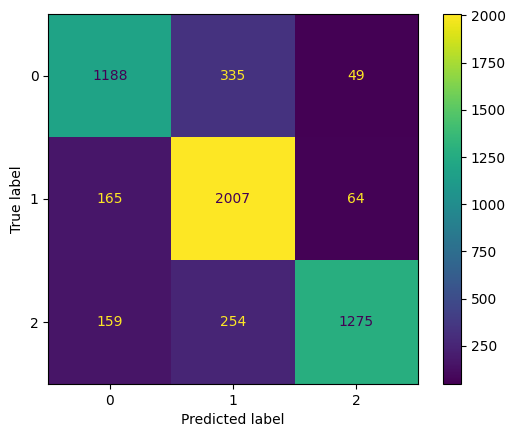

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, rf_pred);

### Adaboost boosting method

In [22]:
ada_classifier = AdaBoostClassifier()
ada_classifier.fit(XV_train, y_train)

AdaBoostClassifier()

In [23]:
ada_pred = ada_classifier.predict(XV_test)

In [24]:
print("AdaBoost Accuracy:", accuracy_score(y_test, ada_pred))

AdaBoost Accuracy: 0.6990538573508006


In [25]:
print("\nAdaBoost Classification Report:")
print(classification_report(y_test, ada_pred))


AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.79      0.65      1572
           1       0.76      0.74      0.75      2236
           2       0.89      0.55      0.68      1688

    accuracy                           0.70      5496
   macro avg       0.73      0.70      0.69      5496
weighted avg       0.74      0.70      0.70      5496



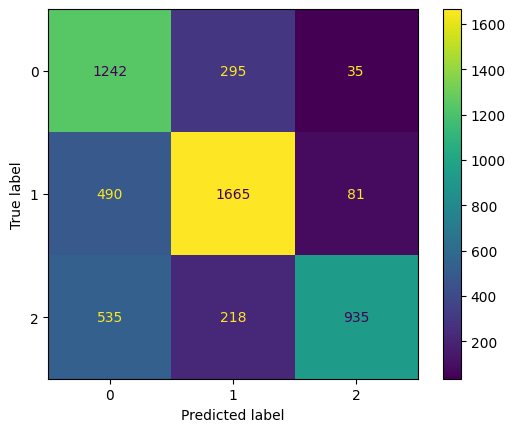

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test, ada_pred);

### Gradient Boosting


Gradient Boosting Machine (GBM) Model:
Accuracy: 0.7469068413391557
Gradient Boosting Machine (GBM) Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.78      0.69      1572
           1       0.77      0.82      0.79      2236
           2       0.93      0.62      0.75      1688

    accuracy                           0.75      5496
   macro avg       0.77      0.74      0.74      5496
weighted avg       0.77      0.75      0.75      5496



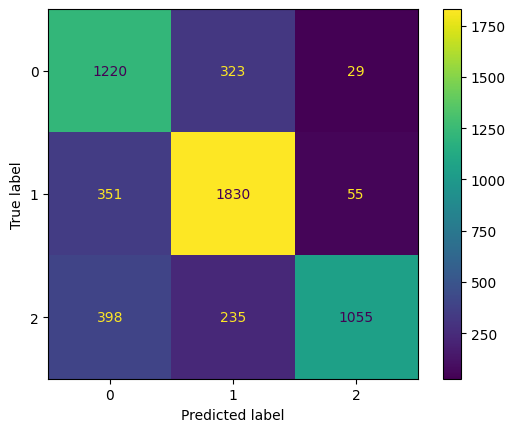

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
# Gradient Boosting Machine (GBM)
gbm_classifier = GradientBoostingClassifier()
gbm_classifier.fit(XV_train, y_train)
y_pred_gbm = gbm_classifier.predict(XV_test)
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
print("\nGradient Boosting Machine (GBM) Model:")
print("Accuracy:", accuracy_gbm)
report_gbm = classification_report(y_test, y_pred_gbm)
print("Gradient Boosting Machine (GBM) Classification Report:")
print(report_gbm)
# If you want to display confusion matrix for GBM, you can use:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gbm)


### LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29568
[LightGBM] [Info] Number of data points in the train set: 21984, number of used features: 805
[LightGBM] [Info] Start training from score -1.264315
[LightGBM] [Info] Start training from score -0.906401
[LightGBM] [Info] Start training from score -1.159663

LightGBM Model:
Accuracy: 0.7967612809315866
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      1572
           1       0.80      0.85      0.82      2236
           2       0.91      0.72      0.80      1688

    accuracy                           0.80      5496
   macro avg       0.80      0.79      0.79      5496
weighted avg       0.81      0.80      0.80      5496



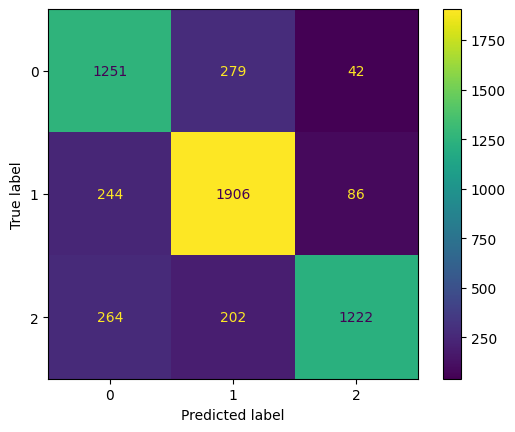

In [28]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# LightGBM
lgb_classifier = lgb.LGBMClassifier()
lgb_classifier.fit(XV_train, y_train)
y_pred_lgb = lgb_classifier.predict(XV_test)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print("\nLightGBM Model:")
print("Accuracy:", accuracy_lgb)
report_lgb = classification_report(y_test, y_pred_lgb)
print("LightGBM Classification Report:")
print(report_lgb)
# If you want to display confusion matrix for LightGBM, you can use:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgb)


## SVM(Support Vector Machine)

### Kernel ---> 'Linear'

In [29]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(XV_train, y_train)

SVC(kernel='linear')

In [30]:
svm_pred = svm_classifier.predict(XV_test)

In [31]:
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f"SVM with linear kernel Accuracy:", svm_accuracy)

SVM with linear kernel Accuracy: 0.8324235807860262


In [32]:
print("\nSVM ( Kernel='linear' ) Classification Report:")
print(classification_report(y_test, svm_pred))


SVM ( Kernel='linear' ) Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1572
           1       0.80      0.88      0.84      2236
           2       0.91      0.81      0.86      1688

    accuracy                           0.83      5496
   macro avg       0.84      0.83      0.83      5496
weighted avg       0.84      0.83      0.83      5496



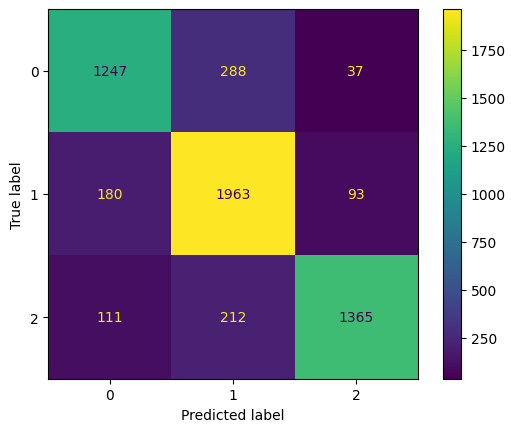

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test,svm_pred);

### Kernel--->'Poly'

In [34]:
svm_classifier = SVC(kernel='poly')
svm_classifier.fit(XV_train, y_train)

SVC(kernel='poly')

In [35]:
svm_pred = svm_classifier.predict(XV_test)

In [36]:
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f"SVM with poly kernel Accuracy:", svm_accuracy)

SVM with poly kernel Accuracy: 0.7807496360989811


In [37]:
print("\nSVM ( Kernel='Poly' ) Classification Report:")
print(classification_report(y_test, svm_pred))


SVM ( Kernel='Poly' ) Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73      1572
           1       0.67      0.97      0.79      2236
           2       0.96      0.70      0.81      1688

    accuracy                           0.78      5496
   macro avg       0.85      0.76      0.78      5496
weighted avg       0.83      0.78      0.78      5496



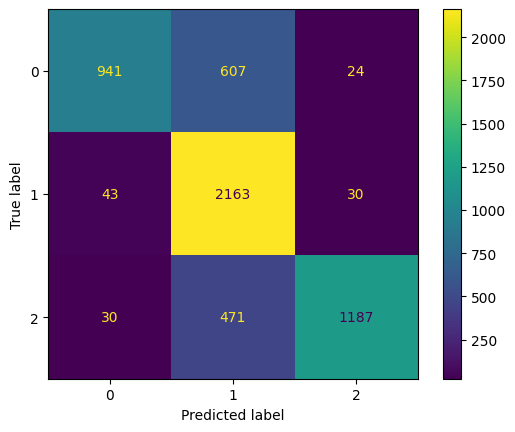

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test,svm_pred);

### Kernel--->'RBF'

In [39]:
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(XV_train, y_train)

SVC()

In [40]:
svm_pred = svm_classifier.predict(XV_test)

In [41]:
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f"SVM with rbf kernel Accuracy:", svm_accuracy)

SVM with rbf kernel Accuracy: 0.8382459970887919


In [42]:
print("\nSVM ( Kernel='RBF' ) Classification Report:")
print(classification_report(y_test, svm_pred))


SVM ( Kernel='RBF' ) Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.81      1572
           1       0.79      0.91      0.84      2236
           2       0.93      0.80      0.86      1688

    accuracy                           0.84      5496
   macro avg       0.85      0.83      0.84      5496
weighted avg       0.85      0.84      0.84      5496



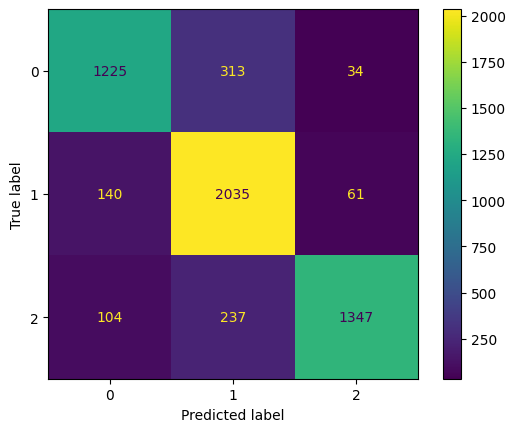

In [43]:
ConfusionMatrixDisplay.from_predictions(y_test,svm_pred);

# Decision Tree

In [44]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
decision_tree=DecisionTreeClassifier(max_depth=20)


In [45]:
decision_tree.fit(XV_train,y_train)

DecisionTreeClassifier(max_depth=20)

In [46]:
dt_pred=decision_tree.predict(XV_test)

In [47]:
dt_accuracy=accuracy_score(y_test,dt_pred)
print(f"Decision Tree Accuracy with depth=20:", dt_accuracy)

Decision Tree Accuracy with depth=20: 0.6413755458515283


In [48]:
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, dt_pred))


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.83      0.60      1572
           1       0.77      0.66      0.71      2236
           2       0.91      0.44      0.59      1688

    accuracy                           0.64      5496
   macro avg       0.72      0.64      0.64      5496
weighted avg       0.73      0.64      0.64      5496



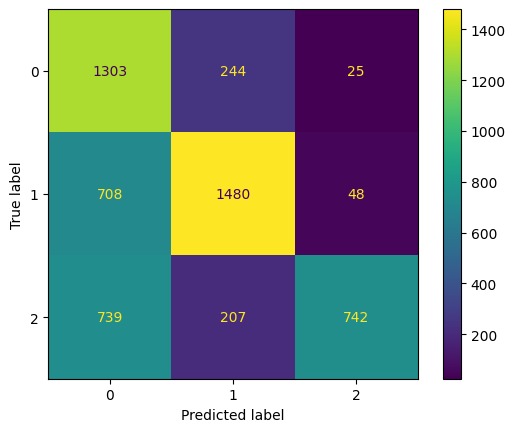

In [49]:
ConfusionMatrixDisplay.from_predictions(y_test,dt_pred);

# Logistic Regression

In [50]:
logistic_model = LogisticRegression(max_iter=100)

In [51]:
logistic_model.fit(XV_train, y_train)

LogisticRegression()

In [52]:
y_pred_logistic = logistic_model.predict(XV_test)

In [53]:
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("Logistic Regression Model:")
print(f"Accuracy: {accuracy_logistic}")

Logistic Regression Model:
Accuracy: 0.8309679767103348


In [54]:
report_logistic = classification_report(y_test, y_pred_logistic)
print("Logistic Regression Classification Report:")
print(report_logistic)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1572
           1       0.79      0.88      0.84      2236
           2       0.91      0.81      0.85      1688

    accuracy                           0.83      5496
   macro avg       0.84      0.82      0.83      5496
weighted avg       0.84      0.83      0.83      5496



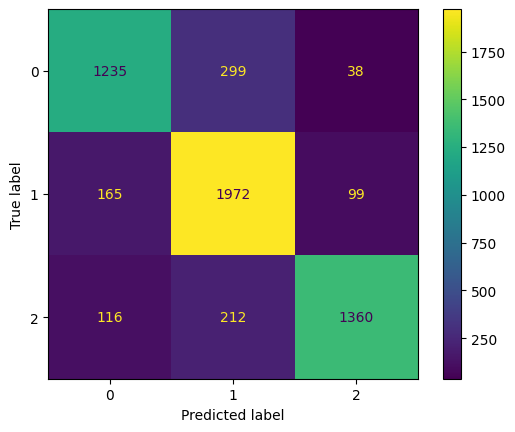

In [55]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_logistic);

# Naive Bayes

In [56]:
nb_classifier = MultinomialNB()

In [57]:
nb_classifier.fit(XV_train, y_train)

y_pred = nb_classifier.predict(XV_test)

In [58]:
accuracy = accuracy_score(y_test, y_pred)
print("Naive Bayes Model:")
print("Accuracy:", accuracy)

Naive Bayes Model:
Accuracy: 0.7780203784570596


In [59]:
report_naive_bayes = classification_report(y_test, y_pred)
print("Naive Bayes Classification Report:")
print(report_naive_bayes)

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.58      0.71      1572
           1       0.68      0.95      0.79      2236
           2       0.91      0.73      0.81      1688

    accuracy                           0.78      5496
   macro avg       0.84      0.75      0.77      5496
weighted avg       0.82      0.78      0.77      5496



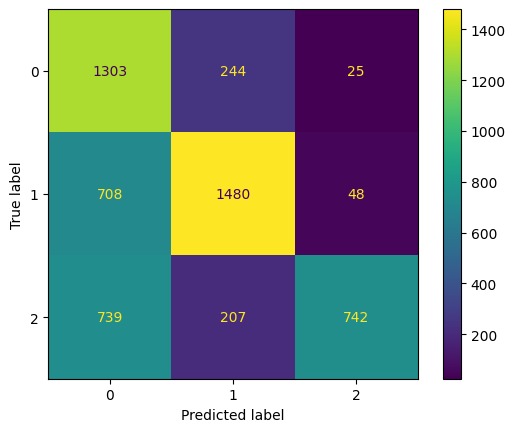

In [60]:
ConfusionMatrixDisplay.from_predictions(y_test,dt_pred);

# K Nearest Neightbors (KNN)

K-Nearest Neighbors (KNN) Model:
Accuracy: 0.5081877729257642
K-Nearest Neighbors (KNN) Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.95      0.54      1572
           1       0.73      0.07      0.12      2236
           2       0.90      0.68      0.77      1688

    accuracy                           0.51      5496
   macro avg       0.67      0.57      0.48      5496
weighted avg       0.68      0.51      0.44      5496



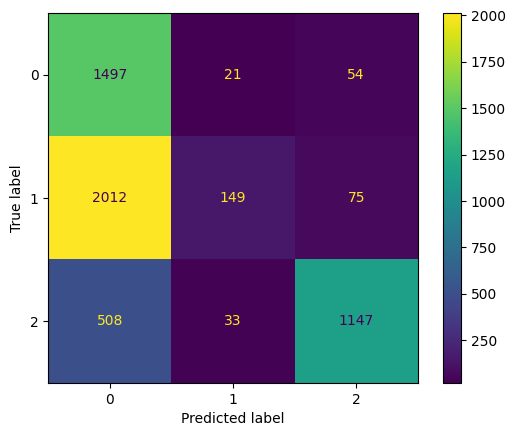

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# K-Nearest Neighbors (KNN)
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(XV_train, y_train)
y_pred_knn = knn_classifier.predict(XV_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("K-Nearest Neighbors (KNN) Model:")
print("Accuracy:", accuracy_knn)
report_knn = classification_report(y_test, y_pred_knn)
print("K-Nearest Neighbors (KNN) Classification Report:")
print(report_knn)
# If you want to display confusion matrix for KNN, you can use:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)


# Test

In [62]:
def output_lable(n):
    if n == 0:
        return "The Text Sentement is Negative"
    elif n == 1:
        return "The Text Sentement is Neutral"
    elif n == 2:
        return "The Text Sentement is Positive"

def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wp)
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_lr = logistic_model.predict(new_xv_test)

    return print((output_lable(pred_lr[0])))

text = input("Enter Text to Classify ")
manual_testing(text)

Enter Text to Classify Hello
The Text Sentement is Neutral


# Accuracy Plots

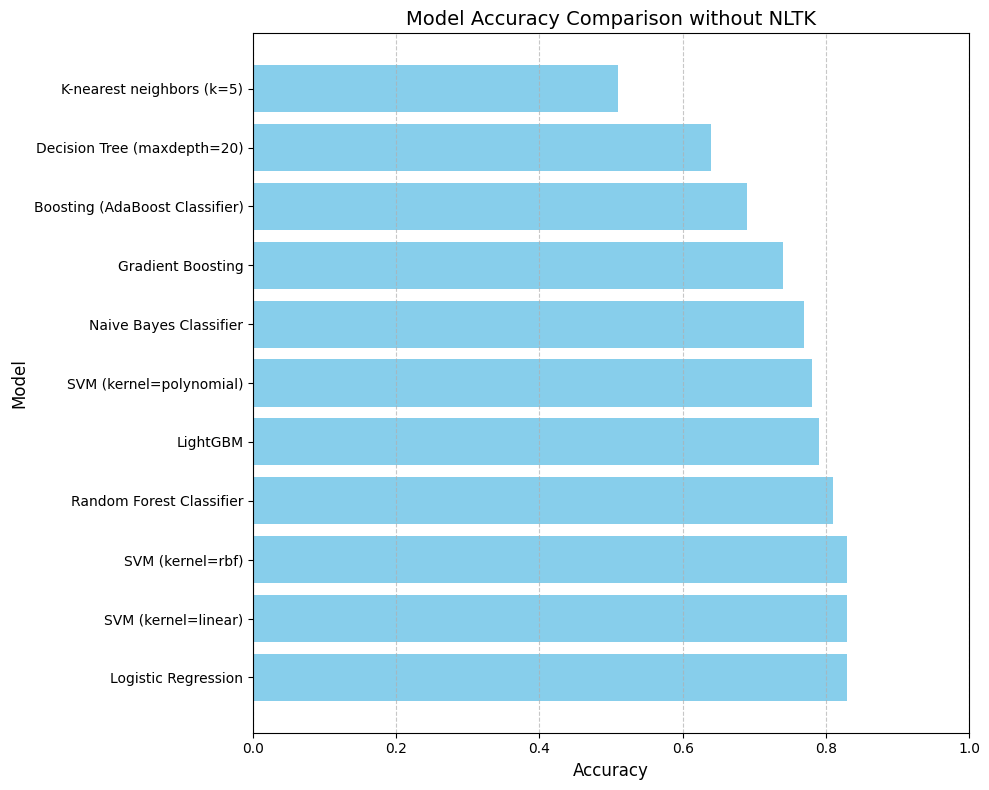

In [63]:
import matplotlib.pyplot as plt

# Model names and corresponding accuracy values
models = [
    "Decision Tree (maxdepth=20)",
    "Logistic Regression",
    "Naive Bayes Classifier",
    "K-nearest neighbors (k=5)",
    "Random Forest Classifier",
    "Boosting (AdaBoost Classifier)",
    "Gradient Boosting",
    "LightGBM",
    "SVM (kernel=linear)",
    "SVM (kernel=polynomial)",
    "SVM (kernel=rbf)"
]

accuracies = [
    0.64,  # Decision Tree
    0.83,  # Logistic Regression
    0.77,  # Naive Bayes
    0.51,  # K-nearest neighbors
    0.81,  # Random Forest
    0.69,  # Boosting
    0.74,  # Gradient Boosting
    0.79,  # LightGBM
    0.83,  # SVM (linear)
    0.78,  # SVM (polynomial)
    0.83   # SVM (rbf)
]

# Sort model names and accuracies based on accuracies in descending order
sorted_data = sorted(zip(models, accuracies), key=lambda x: x[1], reverse=True)

sorted_models = [x[0] for x in sorted_data]
sorted_accuracies = [x[1] for x in sorted_data]

# Create a horizontal bar plot in descending order of accuracies
plt.figure(figsize=(10, 8))
plt.barh(sorted_models, sorted_accuracies, color='skyblue')
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.title('Model Accuracy Comparison without NLTK', fontsize=14)
plt.xlim(0, 1)  # Set the x-axis limit to range from 0 to 1 (assuming accuracy range)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines to x-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()